# Introduction
In February 2006, Prosper company started helping people borrow thousands of dollars online from strangers using a peer-to-peer lending system. Individual investors enjoyed the returns (historical return average 5.6%) from the lending, and borrowers enjoyed similar cost advantages compared with rates at a bank or credit union. Prosper alone facilitated \$1.5 billion in Borrower Loan originations during 2020 and \$18.2 billion in Borrower Loan originations since it first launched in 2006.
 
There are many loans on the peer-to-peer lending platform that inventors need to pick to put their money on, which is time-consuming and sometimes unclear which loan to pick. To address this issue, we start building a roboadviser that automatically evaluates loans and advises investors on which loan to put their money on.

To achieve that, we build a model from historical data and use it in roboadviser application to select high-quality loans to save investors time and maximize returns.

In [41]:
from importlib import reload # TODO remove this block
import sys
reload(sys.modules['title_parser'])
#reload(sys.modules['util'])
#reload(sys.modules['imputer'])

!pip install string-grouper
!pip install wordsegment
!pip install pyspellchecker

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import collections

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Custom python modules used for feature engineering
from encoders import Encoders
from replacenan import ReplaceNaN
from imputer import Imputer
from title_parser import TitleParser
from util import *

import warnings
warnings.filterwarnings('ignore')

# The data is located on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

We used LendingClub LLC, a peer-to-peer lending company headquartered in San Francisco, historical loan data which is hosted on [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). The historical data spans between June 2007 and December 2018.

Since the loan status outcome is also determind by the economic condition, we web scrap seasonally adjusted unemployment data from [U.S. Bureau of Labor Statistic](https://www.bls.gov/charts/state-employment-and-unemployment/state-unemployment-rates-map.htm)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/207-final/lc_loans_2007_to_2018Q4.csv', engine='c', low_memory='False', warn_bad_lines=False)
unemployment = pd.read_csv('/content/drive/My Drive/207-final/state_unemployment.csv', engine='c')
unemployment.set_index('Code', inplace=True)

# Target Classes
This project goal is to build a model that predicts if a given loan at the time of issue will be `Fully Paid` or `Charged Off`. For that reason, we will pick records with only `Fully Paid` and `Charged Off` loan status to extract insight and use it for prediction.

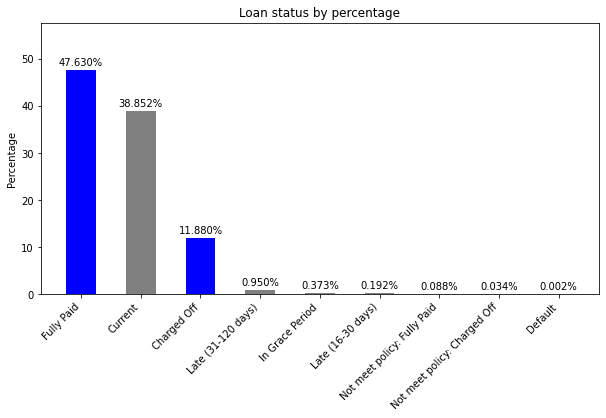

In [ ]:
def show_class_composition(df):
  """Displaying class composition for the given dataset
  Parameters
  ----------
  df : A panda dataset that has "loan_status" feature
  """
  summary = df['loan_status'].value_counts().rename_axis('unique_values').reset_index(name='counts')
  summary['percent'] = (100. * (summary['counts'] / summary['counts'].sum())).round(3)
  summary['unique_values'] = summary['unique_values'].replace(
      ['Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'],
      ['Not meet policy: Fully Paid', 'Not meet policy: Charged Off'])
  colors = ['blue', 'gray', 'blue', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray']
  plt.rcParams["figure.figsize"] = [10, 5]
  fig, ax = plt.subplots()
  pps = ax.bar(summary['unique_values'], summary['percent'], width=0.5, align='center', color=colors)
  ax.set_ylim([0, summary['percent'].max()+10])
  plt.xticks(rotation=45, ha='right')
  # Putting percentage value on top of each bar
  for p in pps:
    y = p.get_height()
    ax.text(x=p.get_x()+p.get_width()/2, y=y+1, s="{:.3f}%".format(y), ha='center')
  ax.set_title("Loan status by percentage")
  ax.set_ylabel("Percentage")
  plt.show()

show_class_composition(df)

# Data cleanup

We have 151 features out of which 19 of them are introduced on September 2012 and 14 features are introduced on January 2016. Since the feature value is NaN before the introduction of the new features, we removed all records before January 2016.

Features introduced on September 2012: `total_rev_hi_lim`, `avg_cur_bal`, `mo_sin_old_rev_tl_op`, `mo_sin_rcnt_rev_tl_op`, `mo_sin_rcnt_tl`, `num_accts_ever_120_pd`, `num_actv_bc_tl`, `num_actv_rev_tl`, `num_bc_tl`, `num_il_tl`, `num_op_rev_tl`, `num_rev_accts`, `num_rev_tl_bal_gt_0`, `num_tl_30dpd`, `num_tl_90g_dpd_24m`, `num_tl_op_past_12m`, `pct_tl_nvr_dlq`, `tot_hi_cred_lim`, and `total_il_high_credit_limit`

Features introduced on January 2016: `open_acc_6m`, `open_act_il`, `open_il_12m`, `open_il_24m`, `1-mths_since_rcnt_il`, `total_bal_il`, `open_rv_12m`, `open_rv_24m`, `max_bal_bc`, `all_util`, `inq_fi`, `total_cu_tl`, `inq_last_12m`, and `il_util`

We didn't add description for each feature to keep the notebook concise but the data dictionery is available [here](data/LCDataDictionary.xlsx)

In [42]:
# Initialing objects that will be used for feature engineering
encoders = Encoders()
replaceNaN = ReplaceNaN()
imputer = Imputer()
scaler = StandardScaler()
vectorizer = TfidfVectorizer(stop_words='english', max_features = 100)# min_df=0.1)
titleParser = TitleParser()
df_records = {}
df_features = {}

df_records["Original"] = df.shape[0]
df_features["Original"] = df.shape[1]
# Removing loans other than "Fully Paid" and "Charged Off"
df_clean = remove_invalid_rows(df)
df_records["After invalid rows removed"] = df_clean.shape[0]
df_clean = convert_to_date(df_clean) # String datatype to datetime conversion
# Taking data starting from January 2016 based on the above reason
df_clean = get_data_since(df_clean, datetime.date(2016, 1, 1))

# The following three feature generators do mapping from one column to another column
df_clean = add_issue_date_feature(df_clean) # Date to integer converion
df_clean = add_unemployment_rate(unemployment, df_clean)
df_clean = months_since_earliest_cr_line(df_clean)
df_features["After generating new features"] = df_clean.shape[1]
df_clean = remove_features(df_clean)
df_records["After removing data before Jan 2016"] = df_clean.shape[0]
df_features["After removing features"] = df_clean.shape[1]

# Splitting the data into training, dev and test
train_data, dev_data, test_data = split_data(df_clean)


In [43]:

# Title cleanup, spelling correction and reducing to similar titles
train_data_title = titleParser.fit_transform(train_data[['emp_title']].copy())
dev_data_title = titleParser.transform(dev_data[['emp_title']])

# Building matrix of TF-IDF features for title
train_title_matrix = vectorizer.fit_transform(train_data_title['new_title'])
dev_title_matrix = vectorizer.transform(dev_data_title['new_title'])

# Converting it to pandas to make it ready for merge with other features
train_title_matrix = pd.DataFrame(train_title_matrix.todense())
dev_title_matrix = pd.DataFrame(dev_title_matrix.todense())

# Saving memory
#df = None
#unemployment = None
train_data_title = None
dev_data_title = None
df_clean = None

In [45]:
# Removing 'emp_title' after completing feature extraction
train_data.drop(['emp_title'], axis=1, inplace=True)
dev_data.drop(['emp_title'], axis=1, inplace=True)

# Replaces some known features NaN value with 0 value
# We performed analysis on each feature to identify which NaN represents 0
train_data = replaceNaN.fit_transform(train_data)
dev_data = replaceNaN.transform(dev_data)

# Encode categorical features
encode_features = ['home_ownership', 'verification_status', 'purpose',
                   'application_type', 'term', 'grade', 'sub_grade', 'emp_length',
                   'initial_list_status', 'disbursement_method', 'loan_status']
train_data = encoders.fit_transform(train_data, encode_features)
dev_data = encoders.transform(dev_data)
df_features["After Categorical Encoding"] = train_data.shape[1]

# Splitting into Matrix and Label
train_data, train_label = get_ML(train_data, 'loan_status=Fully Paid')
dev_data, dev_label = get_ML(dev_data, 'loan_status=Fully Paid')

# It uses KNN to impute NaN values
train_data = imputer.fit_transform(train_data)
dev_data = imputer.transform(dev_data)
#test_data = imputer.transform(test_data)

# Merge title features matrix with the rest of features
# TODO - it needs to be done before imputer
train_data = pd.concat([train_data, train_title_matrix], axis=1)
dev_data = pd.concat([dev_data, dev_title_matrix], axis=1)
df_features["After Title Features"] = train_data.shape[1]

# Saving memory
train_title_matrix = None
dev_title_matrix = None

# Since regularized methods apply a penalty to the coefficients, we need to ensure our coefficients are on a common scale.
scaled_train_data = scaler.fit_transform(train_data)
scaled_dev_data = scaler.transform(dev_data)
# Converting from ndarray type to panda dataframe type
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_dev_data = pd.DataFrame(scaled_dev_data, columns=dev_data.columns)

# Features and Records size summary

In [ ]:
# Total records size summary
pd.DataFrame.from_dict(df_records, orient='index', columns=['Record Size']).style.format('{:,}')

,Record Size
Original,"2,260,701"
After invalid rows removed,"1,345,310"
After removing data before Jan 2016,"490,309"


In [ ]:
# Feature size summary
pd.DataFrame.from_dict(df_features, orient='index', columns=['Features Size'])

,Features Size
Original,151
After generating new features,155
After removing features,90
After Categorical Encoding,151


In [ ]:
# Sample data
pd.set_option('display.max_columns', None)
train_data[:3]

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_year,issue_month,unemployment_rate,earliest_cr_line_months,home_ownership=MORTGAGE,home_ownership=NONE,home_ownership=OWN,home_ownership=RENT,verification_status=Source Verified,verification_status=Verified,purpose=credit_card,purpose=debt_consolidation,purpose=home_improvement,purpose=house,purpose=major_purchase,purpose=medical,purpose=moving,purpose=other,purpose=renewable_energy,purpose=small_business,purpose=vacation,purpose=wedding,application_type=Joint App,term= 60 months,grade=B,grade=C,grade=D,grade=E,grade=F,grade=G,sub_grade=A2,sub_grade=A3,sub_grade=A4,sub_grade=A5,sub_grade=B1,sub_grade=B2,sub_grade=B3,sub_grade=B4,sub_grade=B5,sub_grade=C1,sub_grade=C2,sub_grade=C3,sub_grade=C4,sub_grade=C5,sub_grade=D1,sub_grade=D2,sub_grade=D3,sub_grade=D4,sub_grade=D5,sub_grade=E1,sub_grade=E2,sub_grade=E3,sub_grade=E4,sub_grade=E5,sub_grade=F1,sub_grade=F2,sub_grade=F3,sub_grade=F4,sub_grade=F5,sub_grade=G1,sub_grade=G2,sub_grade=G3,sub_grade=G4,sub_grade=G5,emp_length=1 year,emp_length=10+ years,emp_length=2 years,emp_length=3 years,emp_length=4 years,emp_length=5 years,emp_length=6 years,emp_length=7 years,emp_length=8 years,emp_length=9 years,emp_length=< 1 year,initial_list_status=w,disbursement_method=DirectPay,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,

# Class composition
The data has a class imbalance problem that can potentially lead to poor model performance specifically for the minority class. To address that issue, we expermented with different subsampling for training data including up-sampling, SMOTE and ROSE methods. We get similar results and go with the simpler version which is up-sampling.

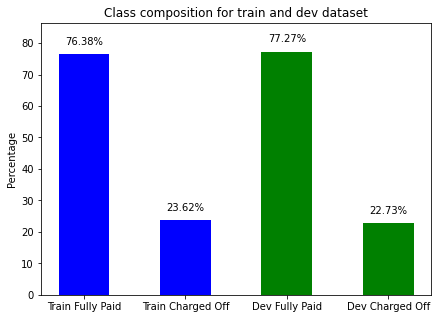

In [ ]:
def show_class_frequencies(train_label, dev_label):
  """Bar plot to show the composition of classes in the training and dev dataset
  Parameters
  ----------
  train_label : Label data for training dataset
  dev_label : Label data for dev dataset
  """
  # Generating summary data for each class
  status_count_train = train_label.value_counts()
  status_count_dev = dev_label.value_counts()
  plt.rcParams["figure.figsize"] = [7, 5]
  fully_paid_train = ((status_count_train[1]/len(train_label))*100)
  charged_off_train = ((status_count_train[0]/len(train_label))*100)
  fully_paid_dev = ((status_count_dev[1]/len(dev_label))*100)
  charged_off_dev = ((status_count_dev[0]/len(dev_label))*100)
  y = [fully_paid_train, charged_off_train, fully_paid_dev, charged_off_dev]
  x = ['Train Fully Paid', 'Train Charged Off', 'Dev Fully Paid', 'Dev Charged Off']

  fig, ax = plt.subplots()
  pps = ax.bar(x, y, width=0.5, align='center', color=['b', 'b', 'g', 'g'])
  ax.set_ylim([0, fully_paid_train+10])
  # Putting percentage value on top of each bar
  for p in pps:
    y = p.get_height()
    ax.text(x=p.get_x()+p.get_width()/2, y=y+3, s="{:.2f}%".format(y), ha='center')
  ax.set_title("Class composition for train and dev dataset")
  ax.set_ylabel("Percentage")
  plt.show()

show_class_frequencies(train_label, dev_label)

# Model building
When the roboadvisor application advises investors on which loan to put their money on, it needs to sort out loans based on investor risk tolerance level.

To balance the risk and reward expectations of the roboadvisor application, we will focus on probabilistic models, including Naive Bayes, Logistic regression, and Gaussian Mixture Model.

#### Gaussian Naive Bayes (GaussianNB)

In [46]:
def build_gaussian_nb(train_data, train_label, dev_data, dev_label):
  """Building a Gaussian Naive Bayes (GaussianNB) model"""
  # Addressing class imbalance problem
  train_x, train_y = up_sample(train_data, train_label)
  smoothings, f1_scores = [], []
  best_f1, best_smoothing = 0, 0
  best_clf = None
  # Picking the best smoothing
  for smoothing in [0.001]: #[0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1]:
    clf = GaussianNB(var_smoothing=smoothing)
    clf.fit(train_x, train_y)
    dev_predict = clf.predict(dev_data)
    f1_score = round(metrics.f1_score(dev_label, dev_predict), 3)
    f1_scores.append(f1_score)
    smoothings.append(smoothing)
    # Finding the best smoothing hyperparameter
    if f1_score > best_f1:
      best_f1 = f1_score
      best_smoothing = smoothing
      best_clf = clf
  # Displaying the findings
  scores = pd.DataFrame({'Smoothing': smoothings, 'F1 Score': f1_scores})
  print("F1 score for different smoothing")
  print(scores)
  print(f"Best smoothing is {best_smoothing} resulting {best_f1} F1 Score")
  
  return best_clf

gaussian_nb_clf = build_gaussian_nb(train_data, train_label, dev_data, dev_label)

F1 score for different smoothing
   Smoothing  F1 Score
0      0.001       0.4
Best smoothing is 0.001 resulting 0.4 F1 Score


#### Logistic Regression

For Logistic Regression, we use Elastic net regularization that combines the two penalities by incorporating both L1 and L2 regularization.

In [8]:
from imblearn.over_sampling import ADASYN # Meh
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE # Meh

def logistic_regression_with_elasticnet(train_data, train_label, dev_data, dev_label):
  """Building logestic regression model using Elastic net"""

  # Addressing class imbalance problem
  train_x, train_y = up_sample(train_data, train_label)
  #train_x, train_y = train_data, train_label

  # Intitializing regularization and result tracking variables
  regularization = [0.0000001, 0.000001, 0.00001, 0.0001]
  regularization = [0.0001]
  l1_ratios = [x for x in np.arange(0.1, 1.0, 0.1)]
  l1_ratios = [0.1, 0.5, 0.9]
  l1_ratios = [0.5]
  strengths, ratios, f1_scores = [], [], []
  best_f1, best_c, best_l1_ratio = 0, 0, 0
  best_model = None
  # Evaluating Logistic Regression for each regularization C and L1 ratio
  for i, c in enumerate(regularization):
    for r in l1_ratios:
      np.random.seed(0)
      clf = LogisticRegression(C=c, l1_ratio = r, solver="saga", multi_class="ovr", penalty="elasticnet", tol=0.001, n_jobs = -10)#, class_weight="balanced")
      clf.fit(train_x, train_y)
      dev_predict = clf.predict(dev_data)
      precision_score = metrics.precision_score(dev_label, dev_predict)
      f1_score = round(metrics.f1_score(dev_label, dev_predict), 3)
      # Finding the best smoothing hyperparameter
      if f1_score > best_f1:
        best_f1 = f1_score
        best_c = c
        best_l1_ratio = r
        best_model = clf
      #if f1_score < 0.80: # TODO remove filter condition
      #  continue
      
      strengths.append(c)
      ratios.append(r)
      f1_scores.append(f1_score)

  # Building pandas dataframe to display results in table format
  scores = pd.DataFrame(data=np.column_stack((strengths, ratios, f1_scores)),
                         columns=["Inverse of Regularization Strength", "L1 Ratio", "F1 Score"])
  print("F1 score for different inverse of regularization strength and L1 ratio")
  display(scores)
  print(f"Best inverse of regularization strength is {best_c} and L1 ratio is {best_l1_ratio} resulting {best_f1} F1 Score")
  return best_model

#train_data_SMOTE, train_label_SMOTE = SMOTE().fit_resample(scaled_train_data, train_label)
#lr_en_clf = logistic_regression_with_elasticnet(train_data_SMOTE, train_label_SMOTE, scaled_dev_data, dev_label)
lr_en_clf = logistic_regression_with_elasticnet(scaled_train_data, train_label, scaled_dev_data, dev_label)

# class_weight="balanced"
#Inverse of Regularization Strength	L1 Ratio	F1 Score
#0	0.00001	0.6	0.872
#1	0.00001	0.7	0.872
#2	0.00001	0.8	0.872
#3	0.00001	0.9	0.872
# upsampling
#Best inverse of regularization strength is 1e-06 and L1 ratio is 0.1 - 0.9 resulting 0.872 F1 Score
#9	0.000010	0.9	0.872
# SMOTE
#Best inverse of regularization strength is 1e-06 and L1 ratio is 0.1 - 0.9 resulting 0.872 F1 Score


F1 score for different inverse of regularization strength and L1 ratio


,Inverse of Regularization Strength,L1 Ratio,F1 Score
0,0.0001,0.5,0.732


Best inverse of regularization strength is 0.0001 and L1 ratio is 0.5 resulting 0.732 F1 Score


In [7]:
from imblearn.over_sampling import ADASYN # Meh
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE # Meh

def logistic_regression_with_l2(train_data, train_label, dev_data, dev_label):
  """Building logestic regression model using Elastic net"""

  # Addressing class imbalance problem
  train_x, train_y = up_sample(train_data, train_label)
  #train_x, train_y = train_data, train_label

  # Intitializing regularization and result tracking variables
  regularization = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
  strengths, f1_scores = [], []
  best_f1, best_c = 0, 0
  best_model = None
  # Evaluating Logistic Regression for each regularization C and L1 ratio
  for i, c in enumerate(regularization):
    np.random.seed(0)
    clf = LogisticRegression(C=c, tol=0.001, n_jobs = -1)#, class_weight="balanced")
    clf.fit(train_x, train_y)
    dev_predict = clf.predict(dev_data)
    precision_score = metrics.precision_score(dev_label, dev_predict)
    f1_score = round(metrics.f1_score(dev_label, dev_predict), 3)
    # Finding the best smoothing hyperparameter
    if f1_score > best_f1:
      best_f1 = f1_score
      best_c = c
      best_model = clf
    #if f1_score < 0.80: # TODO remove filter condition
    #  continue
    
    strengths.append(c)
    f1_scores.append(f1_score)

  # Building pandas dataframe to display results in table format
  scores = pd.DataFrame(data=np.column_stack((strengths, f1_scores)),
                         columns=["Inverse of Regularization Strength", "F1 Score"])
  print("F1 score for different inverse of regularization strength and L1 ratio")
  display(scores)
  print(f"Best inverse of regularization strength is {best_c} resulting {best_f1} F1 Score")
  return best_model

#train_data_SMOTE, train_label_SMOTE = SMOTE().fit_resample(scaled_train_data, train_label)
#lr_en_clf = logistic_regression_with_elasticnet(train_data_SMOTE, train_label_SMOTE, scaled_dev_data, dev_label)
lr_l2n_clf = logistic_regression_with_l2(scaled_train_data, train_label, scaled_dev_data, dev_label)


KeyboardInterrupt: ignored